In [1]:
%matplotlib notebook

In [2]:
import calour as ca
import numpy as np
import pandas as pd
from calour.training import plot_roc
import matplotlib.pyplot as plt
ca.set_log_level(40)

In [3]:
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
import skbio.stats.distance as ssd
from emperor import Emperor

First, we will load the table with relative abundance of 16S tag sequences (normalized to 100) in Ldlr and ApoE KO along with metadata about all samples in the study using calour (http://biocore.github.io/calour/). 
We are interested in looking at fecal metabolome in this study, so we will filter out all other sample types. Lastly, we just include samples from mice that were fed high-fat diet (HFD) as HFD promoted atherosclerosis in our animal models; this is the phenotype of interest. 

**Description of metadata columns that we use for this analysis**
1. body_habitat : type of sample (fecal, plasma, oral etc.)
2. diet : 'HFD' (High-fat diet) or 'Regular chow' given to mice
3. exposure_type : 'Air' or 'IHH' (intermittent hypoxia and hypercapnia) exposure
4. mouse_number : denotes unique mouse ID for each mouse in the study
5. genotype : 'ApoE KO' (ApoE knockout animals) or 'Ldlr knockout' 
6. age : age of mice in weeks (the study starts at 10 weeks of age)

# Metabolite composition

### Shared and unique features between the animal models

In [4]:
# reading metadata about samples and table with relative abundance of MS1 spectral ions
exp = ca.read('../data/metabolome/features_TSNnorm.txt', '../data/combined_sample_metadata_HFD.txt',
             normalize=100, feature_metadata_file='../data/metabolome/annotations_wStandards.txt')

# only retain fecal samples from mouse fed HFD
exp = exp.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

**QC sequences:** We apply abundance-based filtering within each model, keeping only the features above 10E-01 relative abundance in at least 10% of the samples. 

In [5]:
exp_apoe = exp.filter_samples('genotype', 'ApoE KO')
expf_apoe = exp_apoe.filter_prevalence(cutoff=0.1, fraction=0.1)

exp_ldlr = exp.filter_samples('genotype', 'LDLR knockout')
expf_ldlr = exp_ldlr.filter_prevalence(cutoff=0.1, fraction=0.1)

In [6]:
# features in ldlr
f_ldlr = expf_ldlr.feature_metadata.index
print("Sequences in Ldlr KO: ", len(f_ldlr))

# feature in apoe
f_apoe = expf_apoe.feature_metadata.index
print("Sequences in ApoE KO: ", len(f_apoe))

#shared features
print("Shared sequences in Ldlr and ApoE KO: ", len(f_apoe.intersection(f_ldlr)))

#unique features
print("Unique sequences in ApoE KO: ", len(set(f_apoe) - set(f_apoe.intersection(f_ldlr))))
print("Unique sequences in Ldlr KO: ", len(set(f_ldlr) - set(f_apoe.intersection(f_ldlr))))

Sequences in Ldlr KO:  267
Sequences in ApoE KO:  374
Shared sequences in Ldlr and ApoE KO:  137
Unique sequences in ApoE KO:  237
Unique sequences in Ldlr KO:  130


### Combined analysis of ApoE and LDLR KO animal models TBD

In [7]:
# number of samples in each animal model
exp.sample_metadata.genotype.value_counts()

LDLR knockout    182
ApoE KO          117
Name: genotype, dtype: int64

**QC Sequences:** Below, we perform abundance-based filtering of features to retain only high-quality reliable features that are present above a certain threshold (cutoff) in at least a certain fraction (fraction) of samples within each animal model. 
Here, we use an abundance threshold of 0.1 and we want the feature to be present in atleast 10% of the samples in each animal model.

In [8]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'genotype'
expf = exp.filter_prevalence(field='genotype', cutoff=0.1, fraction=0.1)
expf.shape

(299, 377)

<IPython.core.display.Javascript object>


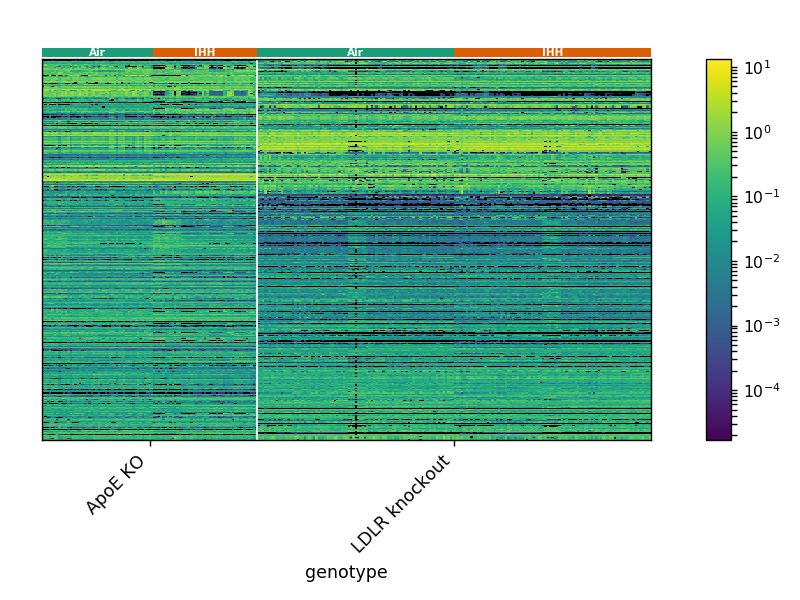

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [9]:
# remove baseline samples
expf = expf.filter_samples(field='age', values=['10', '10.5'], negate=True)

# heatmap to compare all the samples and timepoints across genotypes
expfc = expf.cluster_features()
expfc = expfc.sort_samples(field='age').sort_samples(field='exposure_type').sort_samples(field='genotype')
f = expfc.plot(sample_field='genotype', gui='jupyter', barx_fields=['exposure_type'],
              barx_label_kwargs={'size': 6})

In [10]:
f.save_figure('../figures/animal_comparision_metabolite_filter.pdf')

### Principal Coordinate Analysis using Bray-Curtis distances

In [11]:
metadata = pd.read_table('../data/combined_sample_metadata_HFD.txt', sep='\t', index_col='#SampleID')
bcdm = ssd.DistanceMatrix.read('../data/metabolome/braycurtis_dm/distance-matrix.tsv')

In [12]:
# remove baseline samples
not_baseline =  [sample for sample in metadata.index if metadata.loc[sample, 'age'] not in [10, 10.5] ]
bcdm_no_base = bcdm.filter(ids=not_baseline, strict=False)

#save for QIIME2
bcdm_no_base.to_data_frame().to_csv('../data/metabolome/braycurtis_no_base_dm.txt', sep='\t')

In [13]:
# keep only apoe samples
apoe_samples =  [sample for sample in metadata.index if metadata.loc[sample, 'genotype'] == 'ApoE KO' ]
bcdm_apoe = bcdm_no_base.filter(ids=apoe_samples, strict=False)

#save for QIIME2
bcdm_apoe.to_data_frame().to_csv('../data/metabolome/braycurtis_apoe_dm.txt', sep='\t')

In [14]:
# keep only ldlr samples
ldlr_samples =  [sample for sample in metadata.index if metadata.loc[sample, 'genotype'] == 'LDLR knockout' ]
bcdm_ldlr = bcdm_no_base.filter(ids=ldlr_samples, strict=False)

#save for QIIME2
bcdm_ldlr.to_data_frame().to_csv('../data/metabolome/braycurtis_ldlr_dm.txt', sep='\t')

### Distance boxplots (Bray-Curtis distances)

In [15]:
import seaborn as sns
%matplotlib inline

We used Bray-Curtis distances between every pair of sample to do the analyses below. The data used below (```raw_data```) was generated using ```qiime diversity beta-group-significance``` module (https://docs.qiime2.org/2018.11/plugins/available/diversity/beta-group-significance/)

In [16]:
raw_data = pd.read_table('../data/metabolome/braycurtis_boxplot_raw_data.tsv', sep='\t', index_col=0)

In [17]:
raw_data.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,11548.A22.113.10,11548.A23.119.20,Air_ApoE KO,Air_ApoE KO,0.347220
1,11548.A22.116.20,11548.A23.119.20,Air_ApoE KO,Air_ApoE KO,0.301272
2,11548.A22.116.20,11548.A22.113.10,Air_ApoE KO,Air_ApoE KO,0.267576
3,11548.A21.111.15,11548.A23.119.20,Air_ApoE KO,Air_ApoE KO,0.325358
4,11548.A21.111.15,11548.A22.113.10,Air_ApoE KO,Air_ApoE KO,0.269711


In [18]:
reference = 'Air_ApoE KO'

In [19]:
to_plot = raw_data.loc[raw_data['Group1'] == reference]
to_plot.shape

(11448, 5)

In [20]:
to_plot.Group2.value_counts()

IHH_LDLR knockout    4080
Air_LDLR knockout    4080
IHH_ApoE KO          2160
Air_ApoE KO          1128
Name: Group2, dtype: int64

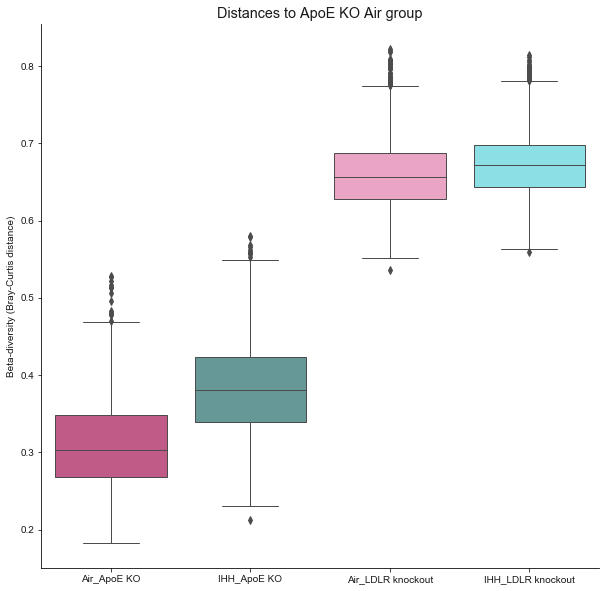

In [21]:
fig, axs = plt.subplots(figsize=(10, 10))
# sns.set_context("paper")
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# matching colors to PCoA
color_palette = {'Air_ApoE KO': '#d14a86', 'IHH_ApoE KO': '#5da09e', 'Air_LDLR knockout': '#f49ac2', 
                 'IHH_LDLR knockout': '#7cecf4'} 

sns.boxplot(x='Group2', y='Distance', data=to_plot, 
            order=['Air_ApoE KO', 'IHH_ApoE KO', 'Air_LDLR knockout', 'IHH_LDLR knockout'],
            linewidth=1, ax=axs, palette=color_palette)

axs.set(title = 'Distances to ApoE KO Air group', ylabel='Beta-diversity (Bray-Curtis distance)', xlabel="")
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

In [22]:
fig.savefig("../figures/braycurtis_boxplot_exposure_genotype.pdf")